 <font size='4'><b>Project 7 - Data Analysis </b></font> 

<a href="https://openclassrooms.com/en/" >Openclassrooms</a>, Data Analyst Course
<br>Project 7 by Michael Orange

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as plt
import pylab 

import scipy.cluster.hierarchy as hierarchy
from sklearn import preprocessing
from sklearn import decomposition

import scipy.stats as st
from collections import Counter

from display_pca import *

[Uploads datasets](#import)

**Mission 1**
- [DataFrame income_disti](#income_disti)
- [DataFrame country_code](#country_code)
- [DataFrame Population](#population)
- [Missing data and anomalies in income_disti](#anomalies)
- [DataFrame GINI](#gini)

**Mission 2**
- [Select a panel of countries (clustering)](#clustering)
- [Plot: Average income (log) per quantiles](#income_quantile)
- [Plot: Lorenz curves](#lorenz)
- [Plot: Evolution of the GINI Index from 2008 to 2016](#gini_evo)
- [GINI Ranking (2007-2009)](#gini_rank)

<h2>Uploads </h2><a id='import'></a>

In [2]:
income_disti = pd.read_csv("data/raw/data-project7.csv")
pop = pd.read_csv("data/raw/pop.csv")
country_codes = pd.read_csv("data/raw/country_codes.csv")
gini_all = pd.read_csv("data/raw/gini.csv")

<h2>Mission 1</h2><a id='mission 1'></a>

<h3>DataFrame income_disti</h3><a id='income_disti'></a>

In [3]:
#converting "income" and "gdpppp" into float
income_disti["income"] = income_disti["income"].str.replace(',', '.').astype(float)
income_disti["gdpppp"] = income_disti["gdpppp"].str.replace(',', '.').astype(float)

In [4]:
income_disti.columns

Index(['country', 'year_survey', 'quantile', 'nb_quantiles', 'income',
       'gdpppp'],
      dtype='object')

In [5]:
income_disti.columns = ['country_alpha3', 'year_survey', 'quantile', 'nb_quantiles', 'income',
       'gdpppp']

income_disti

,country_alpha3,year_survey,quantile,nb_quantiles,income,gdpppp
0,ALB,2008,1,100,728.89795,7297.00000
1,ALB,2008,2,100,916.66235,7297.00000
2,ALB,2008,3,100,1010.91600,7297.00000
3,ALB,2008,4,100,1086.90780,7297.00000
4,ALB,2008,5,100,1132.69970,7297.00000
...,...,...,...,...,...,...
11594,COD,2008,96,100,810.62330,303.19305
11595,COD,2008,97,100,911.78340,303.19305
11596,COD,2008,98,100,1057.80740,303.19305
11597,COD,2008,99,100,1286.60290,303.19305


In [6]:
'{} selected'.format(income_disti.year_survey.sort_values().unique())

'[2004 2006 2007 2008 2009 2010 2011] selected'

In [7]:
#list of countries in income_disti
country_income = income_disti.country_alpha3.unique()
'{} countries are in the dataframe income_disti'.format(len(country_income))

'116 countries are in the dataframe income_disti'

<h3>DataFrame country_code</h3><a id='country_code'></a>

In [8]:
country_code = country_codes[['official_name_en', 'ISO3166-1-Alpha-3']].copy()
country_code.columns = ['country', 'country_alpha3']
country_code

,country,country_alpha3
0,NaN,TWN
1,Afghanistan,AFG
2,Albania,ALB
3,Algeria,DZA
4,American Samoa,ASM
...,...,...
245,Western Sahara,ESH
246,Yemen,YEM
247,Zambia,ZMB
248,Zimbabwe,ZWE


In [9]:
#countries with no country description
country_code.loc[country_code.country.isna()].country_alpha3.unique()

array(['TWN'], dtype=object)

In [10]:
#Adding country name 'Taiwan' to TWN
country_code.loc[country_code['country_alpha3'] == 'TWN', 'country'] = 'Taiwan'

In [11]:
#countries in income_disti and not in country_code
for z in country_income:
    if z not in country_code.country_alpha3.unique():
        print(z)

XKX


In [12]:
#Adding XKX Kosovo
new_row = {'country':'Kosovo', 'country_alpha3':'XKX'}
country_code = country_code.append(new_row, ignore_index=True)

<h3>DataFrame Population</h3><a id='population'></a>

In [13]:
pop.columns

Index(['Domain Code', 'Domain', 'Area Code', 'Area', 'Element Code', 'Element',
       'Item Code', 'Item', 'Year Code', 'Year', 'Unit', 'Value', 'Flag',
       'Flag Description', 'Note'],
      dtype='object')

In [14]:
pop

,Domain Code,Domain,Area Code,Area,Element Code,Element,Item Code,Item,Year Code,Year,Unit,Value,Flag,Flag Description,Note
0,OA,Annual population,2,Afghanistan,511,Total Population - Both sexes,3010,Population - Est. & Proj.,2004,2004,1000 persons,24726.684,X,International reliable sources,NaN
1,OA,Annual population,2,Afghanistan,511,Total Population - Both sexes,3010,Population - Est. & Proj.,2006,2006,1000 persons,26433.049,X,International reliable sources,NaN
2,OA,Annual population,2,Afghanistan,511,Total Population - Both sexes,3010,Population - Est. & Proj.,2007,2007,1000 persons,27100.536,X,International reliable sources,NaN
3,OA,Annual population,2,Afghanistan,511,Total Population - Both sexes,3010,Population - Est. & Proj.,2008,2008,1000 persons,27722.276,X,International reliable sources,NaN
4,OA,Annual population,2,Afghanistan,511,Total Population - Both sexes,3010,Population - Est. & Proj.,2009,2009,1000 persons,28394.813,X,International reliable sources,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1616,OA,Annual population,181,Zimbabwe,511,Total Population - Both sexes,3010,Population - Est. & Proj.,2007,2007,1000 persons,12255.922,X,International reliable sources,NaN
1617,OA,Annual population,181,Zimbabwe,511,Total Population - Both sexes,3010,Population - Est. & Proj.,2008,2008,1000 persons,12379.549,X,International reliable sources,NaN
1618,OA,Annual population,181,Zimbabwe,511,Total Population - Both sexes,3010,Population - Est. & Proj.,2009,2009,1000 persons,12526.968,X,International reliable sources,NaN
1619,OA,Annual population,181,Zimbabwe,511,Total Population - Both sexes,3010,Population - Est. & Proj.,2010,2010,1000 persons,12697.723,X,International reliable sources,NaN


In [15]:
pop.columns = ['Domain Code', 'Domain', 'country_code', 'country', 'Element Code', 'Element',
       'Item Code', 'Item', 'Year Code', 'year_survey', 'Unit', 'population', 'Flag',
       'Flag Description', 'Note']

In [16]:
pop['population'] = pop['population'] * 1000

In [17]:
pop = pop[['country', 'year_survey', 'population']]
pop

,country,year_survey,population
0,Afghanistan,2004,24726684.0
1,Afghanistan,2006,26433049.0
2,Afghanistan,2007,27100536.0
3,Afghanistan,2008,27722276.0
4,Afghanistan,2009,28394813.0
...,...,...,...
1616,Zimbabwe,2007,12255922.0
1617,Zimbabwe,2008,12379549.0
1618,Zimbabwe,2009,12526968.0
1619,Zimbabwe,2010,12697723.0


In [18]:
pop = pd.merge(pop, country_code, how='outer')

In [19]:
#countries with no population 
pop.loc[(pop['population'].isna())&(pop.country_alpha3.isin(country_income))]

,country,year_survey,population,country_alpha3
1621,Taiwan,NaN,NaN,TWN
1642,State of Palestine,NaN,NaN,PSE
1643,Sudan,NaN,NaN,SDN
1645,Swaziland,NaN,NaN,SWZ
1646,The former Yugoslav Republic of Macedonia,NaN,NaN,MKD
1649,Kosovo,NaN,NaN,XKX


In [20]:
#countries named differently on pop and country_code
country_dict = {'Taiwan':'China, Taiwan Province of', 'State of Palestine': 'Palestine', 
               'Sudan' : 'Sudan (former)','The former Yugoslav Republic of Macedonia' : 'North Macedonia'}

for key in country_dict:
    pop.loc[pop['country'] == country_dict[key], 'country'] = pop.loc[pop['country'] == key].country.values
    pop.loc[pop['country'] == key, 'country_alpha3'] = pop.loc[(pop['country'] == key) & (~pop.country_alpha3.isna())].country_alpha3.values
    pop.drop(pop.loc[(pop['country'] == key) & (pop.population.isna())].index, inplace=True)

In [21]:
#Adjusting the numbers for 'China' - Taiwan's population needs to be substracted
pop.loc[pop['country_alpha3'] == 'CHN', 'population'] = \
        pop.loc[pop['country_alpha3'] == 'CHN'].population.values - \
                pop.loc[pop['country_alpha3'] == 'TWN'].population.values

In [22]:
#imputing "Swaziland" (SWZ) and "Kosovo" (XKX) population data
pop.loc[pop['country_alpha3'] == 'SWZ', 'population'] = 1033000
pop.loc[pop['country_alpha3'] == 'SWZ', 'year_survey'] = 2009

pop.loc[pop['country_alpha3'] == 'XKX', 'population'] = 1747383
pop.loc[pop['country_alpha3'] == 'XKX', 'year_survey'] = 2008

#sources: 
## SWZ (https://countryeconomy.com/demography/population)
## XKX (https://data.worldbank.org)

In [23]:
#deleting the countries not categorized
pop.drop(pop.loc[pop.country_alpha3.isna()].index, inplace=True)

In [24]:
#merge population and income_disti
income_disti = pd.merge(income_disti, pop, how='left')

<h3>income_disti : missing data and anomalies</h3><a id='anomalies'></a>

In [25]:
income_disti

,country_alpha3,year_survey,quantile,nb_quantiles,income,gdpppp,country,population
0,ALB,2008,1,100,728.89795,7297.00000,Albania,3002678.0
1,ALB,2008,2,100,916.66235,7297.00000,Albania,3002678.0
2,ALB,2008,3,100,1010.91600,7297.00000,Albania,3002678.0
3,ALB,2008,4,100,1086.90780,7297.00000,Albania,3002678.0
4,ALB,2008,5,100,1132.69970,7297.00000,Albania,3002678.0
...,...,...,...,...,...,...,...,...
11594,COD,2008,96,100,810.62330,303.19305,Democratic Republic of the Congo,60411195.0
11595,COD,2008,97,100,911.78340,303.19305,Democratic Republic of the Congo,60411195.0
11596,COD,2008,98,100,1057.80740,303.19305,Democratic Republic of the Congo,60411195.0
11597,COD,2008,99,100,1286.60290,303.19305,Democratic Republic of the Congo,60411195.0


In [26]:
missing_data = []
for z in income_disti.country_alpha3.unique():
    nb_quant = len(income_disti.loc[income_disti.country_alpha3 == z])
    if nb_quant != 100:
        
        for k in list(range(1,101)): 
            if k not in income_disti.loc[income_disti.country_alpha3 == 'LTU']['quantile'].values:     
                missing_data += [('{} : {} quantiles, quantile {} missing'.format(z, nb_quant, k))]
missing_data

['LTU : 99 quantiles, quantile 41 missing']

In [27]:
#Imputing an approximation for quantile 41 based on the average between quantiles 42 and 40. 

ltu = income_disti.loc[income_disti.country_alpha3 == 'LTU']
ltu_41 = (ltu.loc[income_disti['quantile'] == 42].income.values 
            + ltu.loc[income_disti['quantile'] == 40].income.values) / 2 
'Approx value of quantile 41 : {}'.format(ltu_41)

'Approx value of quantile 41 : [4882.14065]'

In [28]:
#Adding quantile 41
new_row = {'country':'Lithuania', 'country_alpha3':'LTU', 'year_survey' : income_disti.loc[income_disti['country_alpha3'] == 'LTU'].year_survey.unique()[0],
           'quantile' : 41, 
           'nb_quantiles' : 100, 
           'income' : ltu_41[0], 
           'gdpppp' : income_disti.loc[income_disti.country_alpha3 == 'LTU']['gdpppp'].mean(),
           'country': 'Lithuania', 
           'population': income_disti.loc[income_disti.country_alpha3 == 'LTU']['population'].mean()}
income_disti = income_disti.append(new_row, ignore_index=True)

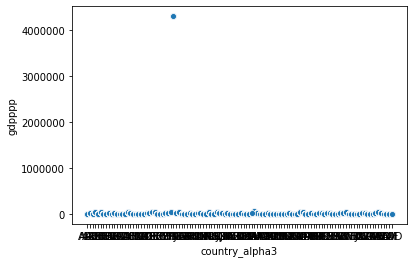

In [29]:
#checking outliers
X = income_disti['country_alpha3']
y = income_disti['gdpppp']
sns.scatterplot(X, y)

In [30]:
'{} GDP PPP of {} is an outlier'.format(income_disti.loc[income_disti.gdpppp > 4000000]['country'].unique()[0], 
                                        income_disti.loc[income_disti.gdpppp > 4000000]['year_survey'].unique()[0])

'Fiji GDP PPP of 2008 is an outlier'

In [31]:
# correcting GDP PPP 2008 of Fiji (source: data.worldbank.org.
income_disti.loc[income_disti['country'] == 'Fiji', 'gdpppp'] = 7777.69

In [32]:
# countries with no GDP PPPP 
income_disti.loc[income_disti.gdpppp.isna()].groupby('country').first()[['year_survey']]

,year_survey
country,
Kosovo,2008
State of Palestine,2009


In [33]:
# Imputation GDP PPP 2008 of XKX (Kosovo) and GDP PPP 2009 of PSE (Palestine) (source: data.worldbank.org.
income_disti.loc[income_disti['country'] == 'Kosovo', 'gdpppp'] = 3254.78
income_disti.loc[income_disti['country'] == 'State of Palestine', 'gdpppp'] = 4721.09

In [34]:
#total population covered by income_disti and % of the total world population - an approximation is accepted based on the total population of 2008
WORLD_POP = 6758000000

income_pop = income_disti.groupby(['country_alpha3'])['population'].first().sum()
ratio_pop = income_pop / WORLD_POP

'Population of {} covered in income_disti, {} % of the world population'.format(int(income_pop), round(ratio_pop*100,2))

'Population of 6235407487 covered in income_disti, 92.27 % of the world population'

<h3>DataFrame GINI</h3><a id='gini'></a>

Data are consistently populated between 2004 and 2016.

In [35]:
gini_all.columns

Index(['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code',
       '1960', '1961', '1962', '1963', '1964', '1965', '1966', '1967', '1968',
       '1969', '1970', '1971', '1972', '1973', '1974', '1975', '1976', '1977',
       '1978', '1979', '1980', '1981', '1982', '1983', '1984', '1985', '1986',
       '1987', '1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995',
       '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004',
       '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013',
       '2014', '2015', '2016', '2017', '2018', '2019'],
      dtype='object')

In [36]:
gini_all.columns = ['country', 'country_alpha3', 'Indicator Name', 'Indicator Code',
       '1960', '1961', '1962', '1963', '1964', '1965', '1966', '1967', '1968',
       '1969', '1970', '1971', '1972', '1973', '1974', '1975', '1976', '1977',
       '1978', '1979', '1980', '1981', '1982', '1983', '1984', '1985', '1986',
       '1987', '1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995',
       '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', 'gini_2004',
       'gini_2005', 'gini_2006', 'gini_2007', 'gini_2008', 'gini_2009', 'gini_2010', 'gini_2011', 'gini_2012', 
        'gini_2013','gini_2014', 'gini_2015', 'gini_2016', '2017', '2018', '2019']

In [37]:
gini = gini_all[['country', 'country_alpha3', 'gini_2004', 'gini_2005','gini_2006','gini_2007', 
                 'gini_2008', 'gini_2009', 'gini_2010', 'gini_2011', 'gini_2012',
                 'gini_2013','gini_2014','gini_2015','gini_2016']]

In [38]:
#country in Income but not in Gini
income_disti.loc[~income_disti.country_alpha3.isin(gini.country_alpha3.unique())].country_alpha3.unique()

array(['TWN'], dtype=object)

In [39]:
# Adding Taiwan
new_row = {'country':'Taiwan', 'country_alpha3':'TWN'}
#append row to the dataframe
gini = gini.append(new_row, ignore_index=True)

**Calculate GINI Index**

In [40]:
def gini_cal(array):
    """Calculate the Gini coefficient """
    array = array.flatten() #all values are treated equally, arrays must be 1d
    if np.amin(array) < 0:
        array -= np.amin(array) #values cannot be negative
    array += 0.0000001 #values cannot be 0
    array = np.sort(array) #values must be sorted
    index = np.arange(1,array.shape[0]+1) #index per array element
    n = array.shape[0]#number of array elements
    return ((np.sum((2 * index - n  - 1) * array)) / (n * np.sum(array))) #Gini coefficient

In [41]:
dict_year = {2004: 'gini_2004', 2006: 'gini_2006', 2007: 'gini_2007', 2008: 'gini_2008', 2009: 'gini_2009', 2010: 'gini_2010', 2011: 'gini_2011'}
no_gini = []

#countries with no gini available but with income information available by quantile 
for key in dict_year:
    no_gini = gini.loc[(gini[dict_year[key]].isna()) 
                       & (gini.country_alpha3.isin(income_disti.loc[income_disti['year_survey'] == key].country_alpha3.unique()))].country_alpha3.values
    
    #calculate GINI for the countries with no gini index
    for z in no_gini:
        X = income_disti.loc[income_disti.country_alpha3 == z].income.values
        gini.loc[gini['country_alpha3'] == z, dict_year[key]] = (gini_cal(X)*100).round(1)

**Mean of GINI Index**

In [53]:
gini['gini_mean'] = gini.iloc[:,2:].mean(axis=1).round(1)

<h2>Mission 2</h2><a id='mission 2'></a>

<h3>Select a panel of countries (clustering)</h3><a id='clustering'></a>

In [56]:
temp = pd.merge(income_disti, gini[['country_alpha3', 'gini_mean']], how='left')
data_pca = temp[['country', 'country_alpha3', 'gdpppp', 'population', 'gini_mean']]

In [57]:
data_pca = data_pca.drop_duplicates(keep = 'first', inplace = False) 
data_pca

,country,country_alpha3,gdpppp,population,gini_mean
0,Albania,ALB,7297.00000,3002678.0,31.8
100,Argentina,ARG,13220.00000,40080160.0,44.4
200,Armenia,ARM,5611.00000,2907618.0,31.4
300,Austria,AUT,36193.00000,8341532.0,30.4
400,Azerbaijan,AZE,8101.00000,8821873.0,28.1
...,...,...,...,...,...
11099,Viet Nam,VNM,2578.00000,84617540.0,36.2
11199,State of Palestine,PSE,4721.09000,3957670.0,34.5
11299,Yemen,YEM,2224.00000,21892146.0,36.3
11399,South Africa,ZAF,9602.00000,49779471.0,63.6


In [59]:
col = ['gdpppp', 'population', 'gini_mean']
X = data_pca[col].values

In [60]:
#number of observations
n = X.shape[0]
# number of variables
p = X.shape[1]

In [61]:
# Normalization (mean centering and variance standardization to 1)
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

In [62]:
# PCA
pca = decomposition.PCA(n_components=p)
pca.fit(X_scaled)

PCA(copy=True, iterated_power='auto', n_components=3, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

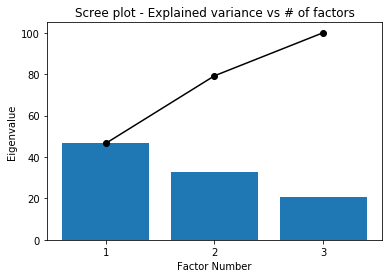

In [63]:
# Scree plot
fig = display_scree_plot(pca)
fig.savefig('data/output_graphics/scree_plot', transparent=True)

In [64]:
# number of component selected
n_comp = 2

In [65]:
# PCA
pca = decomposition.PCA(n_components=n_comp)
pca.fit(X_scaled)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [66]:
data_pca

,country,country_alpha3,gdpppp,population,gini_mean
0,Albania,ALB,7297.00000,3002678.0,31.8
100,Argentina,ARG,13220.00000,40080160.0,44.4
200,Armenia,ARM,5611.00000,2907618.0,31.4
300,Austria,AUT,36193.00000,8341532.0,30.4
400,Azerbaijan,AZE,8101.00000,8821873.0,28.1
...,...,...,...,...,...
11099,Viet Nam,VNM,2578.00000,84617540.0,36.2
11199,State of Palestine,PSE,4721.09000,3957670.0,34.5
11299,Yemen,YEM,2224.00000,21892146.0,36.3
11399,South Africa,ZAF,9602.00000,49779471.0,63.6


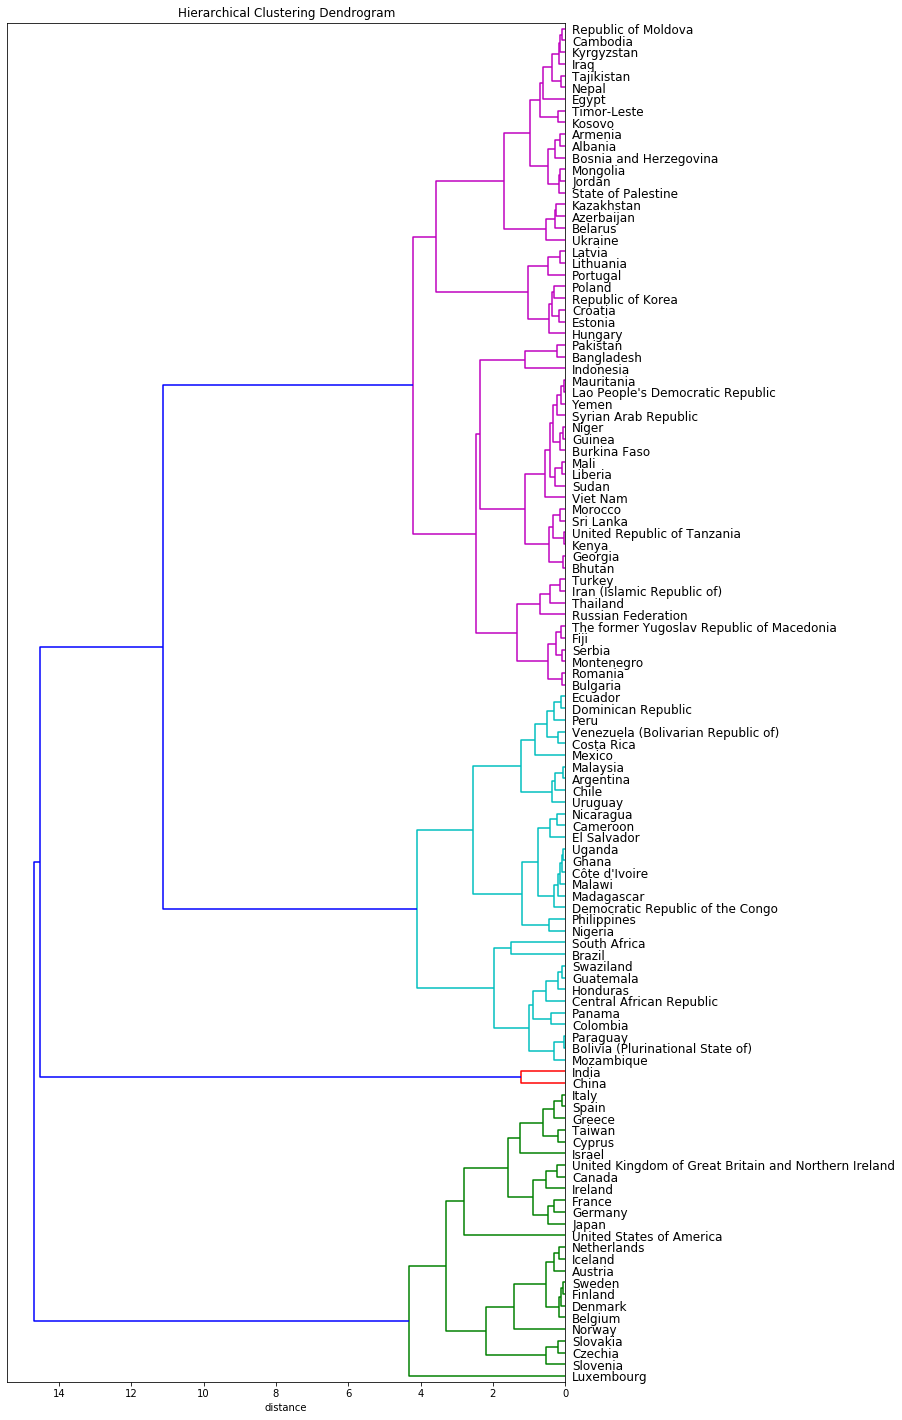

In [67]:
names = data_pca['country'].values

# Clustering hiérarchique
Z = hierarchy.linkage(X_scaled, 'ward')

#dendrogram
fig = plot_dendrogram(Z, names, orientation='top', display='no_display')
fig.savefig('data/output_graphics/dendogram', transparent=True)
plt.close(fig)

plot_dendrogram(Z, names, orientation='left')

In [68]:
num_clusters = 8
clusters = hierarchy.fcluster(Z, num_clusters, criterion='maxclust')

In [69]:
df_cluster = pd.DataFrame(clusters)
df_cluster.columns = ['cluster']
df_cluster.index=data_pca['country']
df_cluster.reset_index().pivot_table(index='cluster', values='country', aggfunc=len)

,country
cluster,
1,24
2,1
3,2
4,11
5,21
6,30
7,8
8,19


In [73]:
X_projected = pca.transform(X_scaled)

In [74]:
X_projected.shape

(116, 2)

In [75]:
df_X_projected = pd.DataFrame(X_projected, index=names, columns=['F'+str(i+1) for i in range(n_comp)])
df_X_projected = pd.concat([df_X_projected, df_cluster], axis=1)
df_X_projected.reset_index(inplace=True)
df_X_projected

,country,F1,F2,cluster
0,Albania,0.321246,-0.233601,8
1,Argentina,-0.531159,-0.206772,5
2,Armenia,0.268118,-0.246313,8
3,Austria,1.956882,0.175359,1
4,Azerbaijan,0.682935,-0.114226,8
...,...,...,...,...
111,Viet Nam,-0.424911,0.090359,6
112,State of Palestine,-0.054202,-0.314717,8
113,Yemen,-0.368594,-0.278303,6
114,South Africa,-2.432187,-0.589080,4


In [76]:
centroids = df_X_projected.pivot_table(index='cluster', values=df_X_projected.columns[1:3], aggfunc=np.mean)
centroids

,F1,F2
cluster,,
1,1.637312,0.279323
2,3.785061,0.547733
3,-2.165179,6.890353
4,-1.740552,-0.533864
5,-0.964477,-0.339192
6,-0.332388,-0.135696
7,0.721248,-0.069589
8,0.255345,-0.179424


In [77]:
#distance from centroid 
for k in centroids.index: 
    df_X_projected.loc[df_X_projected['cluster'] == k, 'distance_centroid'] = np.sqrt(
    (df_X_projected['F1'] - centroids.loc[centroids.index == k]['F1'].values)**2  
    + (df_X_projected['F2'] - centroids.loc[centroids.index == k]['F2'].values)**2)

In [78]:
df_X_projected

,country,F1,F2,cluster,distance_centroid
0,Albania,0.321246,-0.233601,8,0.085312
1,Argentina,-0.531159,-0.206772,5,0.453100
2,Armenia,0.268118,-0.246313,8,0.068098
3,Austria,1.956882,0.175359,1,0.336056
4,Azerbaijan,0.682935,-0.114226,8,0.432532
...,...,...,...,...,...
111,Viet Nam,-0.424911,0.090359,6,0.244257
112,State of Palestine,-0.054202,-0.314717,8,0.337822
113,Yemen,-0.368594,-0.278303,6,0.147132
114,South Africa,-2.432187,-0.589080,4,0.693835


In [79]:
df_cluster.reset_index(inplace=True)
gini = pd.merge(gini, df_cluster, how='left')
gini.set_index('country', inplace=True)

In [82]:
gini.iloc[:, 5:-2]

,gini_2008,gini_2009,gini_2010,gini_2011,gini_2012,gini_2013,gini_2014,gini_2015,gini_2016
country,,,,,,,,,
Aruba,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Afghanistan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Angola,42.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Albania,30.0,NaN,NaN,NaN,29.0,NaN,34.6,32.9,33.7
Andorra,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
"Yemen, Rep.",37.4,NaN,NaN,NaN,NaN,NaN,36.7,NaN,NaN
South Africa,63.0,NaN,63.4,NaN,NaN,NaN,63.0,NaN,NaN
Zambia,NaN,NaN,55.6,NaN,NaN,NaN,NaN,57.1,NaN


In [83]:
#countries with GINI data available from 2008 to 20016 
gini_complete = gini.loc[(gini.iloc[:, 5:-2].isnull().sum(axis=1).values<1) &
                        (~gini.cluster.isna())]

#countries with 1 year of GINI data unavailable from 2008 to 20016 
gini_1_year_missing = gini.loc[(gini.iloc[:, 5:-2].isnull().sum(axis=1).values==1) &
                        (~gini.cluster.isna())]

for k in sorted(gini.cluster.dropna().unique()):
    if gini_complete.loc[gini_complete.cluster == k].index.values.size == 0: 
        gini_complete = gini_complete.append(gini_1_year_missing.loc[gini_1_year_missing.cluster == k])
        
        
#sorted by clusters
for k in sorted(gini.cluster.dropna().unique()):
    print('cluster {}: {}'.format(k, gini_complete.loc[gini_complete.cluster == k].index.values))

cluster 1.0: ['Austria' 'Belgium' 'Cyprus' 'Denmark' 'Spain' 'Finland' 'France'
 'Greece' 'Ireland' 'Italy' 'Netherlands' 'Norway' 'Slovenia' 'Sweden']
cluster 2.0: ['Luxembourg']
cluster 3.0: ['China']
cluster 4.0: ['Colombia' 'Honduras' 'Panama' 'Paraguay']
cluster 5.0: ['Costa Rica' 'Dominican Republic' 'Ecuador' 'Peru' 'El Salvador'
 'Uruguay']
cluster 6.0: ['Bulgaria' 'Georgia' 'Indonesia' 'Romania' 'Russian Federation'
 'Thailand' 'Turkey']
cluster 7.0: ['Estonia' 'Croatia' 'Hungary' 'Lithuania' 'Latvia' 'Poland' 'Portugal']
cluster 8.0: ['Armenia' 'Belarus' 'Kazakhstan' 'Ukraine' 'Kosovo']


In [84]:
#select the country from gini_complete the closest to the cluster centroid (the most representative of the cluster)
country_selected = []

for k in sorted(gini_complete.cluster.unique()):
    select = np.min(df_X_projected.loc[(df_X_projected.cluster ==k) 
                                       & df_X_projected.country.isin(gini_complete.index)]).country
    country_selected.append(select)

country_selected

['Austria',
 'Luxembourg',
 'China',
 'Colombia',
 'Costa Rica',
 'Bulgaria',
 'Croatia',
 'Armenia']

<h3>Plot: Average income (log) per quantiles</h3><a id='income_quantile'></a>

In [85]:
#styles
sns.set_style("darkgrid")

In [87]:
select_quantile = income_disti[['country', 'quantile', 'income']]
select_quantile = select_quantile.loc[select_quantile['country'].isin(country_selected)]
select_quantile = select_quantile.pivot_table(
    index=['quantile'], columns = ["country"], values=["income"], aggfunc=sum)

In [88]:
select_quantile

income                                                      \
country      Armenia     Austria     Bulgaria         China     Colombia   
quantile                                                                   
1          366.61780   2958.0764    271.09310     16.719418     62.60506   
2          535.32733   4893.4673    614.30676    234.150730    135.32379   
3          611.64560   5459.6490    796.17330    282.894900    191.87814   
4          658.33940   5923.5854    963.79090    323.826500    244.67137   
5          690.84710   6380.2780   1048.52170    362.260600    290.17600   
...              ...         ...          ...           ...          ...   
96        3229.55370  33914.1050  12422.03200   7588.195000  11975.12400   
97        3466.66500  36080.9020  13820.51400   8317.553000  13984.85000   
98        3758.60180  39450.5550  15152.43500   9382.284000  16993.29700   
99        4320.28960  44950.3120  18330.70700  11071.510000  22631.80700   
100       6566.15900  72216.6800  28613.78100  17091.404000  50671.12500   

                                                
country    Costa Rica     Croatia   Luxembourg  
quantile                                        
1           275.65390   1355.1073    5780.8374  
2           531.94403   2021.9999    7315.2686  
3           657.80820   2347.5000    7891.2456  
4           781.08844   2502.7769    8312.0310  
5           893.52660   2687.7612    8945.6380  
...               ...         ...          ...  
96        17408.49000  16973.7950   53724.6300  
97        19879.33600  18721.7990   58382.3120  
98        22595.17400  20509.8240   65280.2200  
99        29417.61100  23797.4940   77673.3700  
100       57881.08000  37576.4650  114823.6800  

[100 rows x 8 columns]

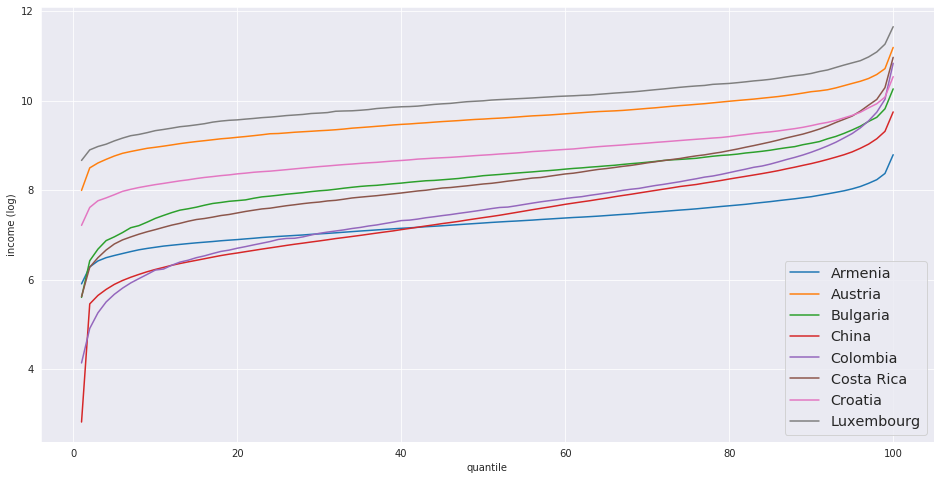

In [89]:
fig = plt.figure(figsize=(16,8))

for k in range(select_quantile.shape[1]): 
    plt.plot(np.log(select_quantile[select_quantile.columns[k]]), label=select_quantile.columns[k][1])

plt.grid(True)
plt.legend(loc='lower right',fontsize = 'x-large')
plt.xlabel('quantile')
plt.ylabel('income (log)')
plt.show()

<h3>Plot: Lorenz curves</h3><a id='lorenz'></a>

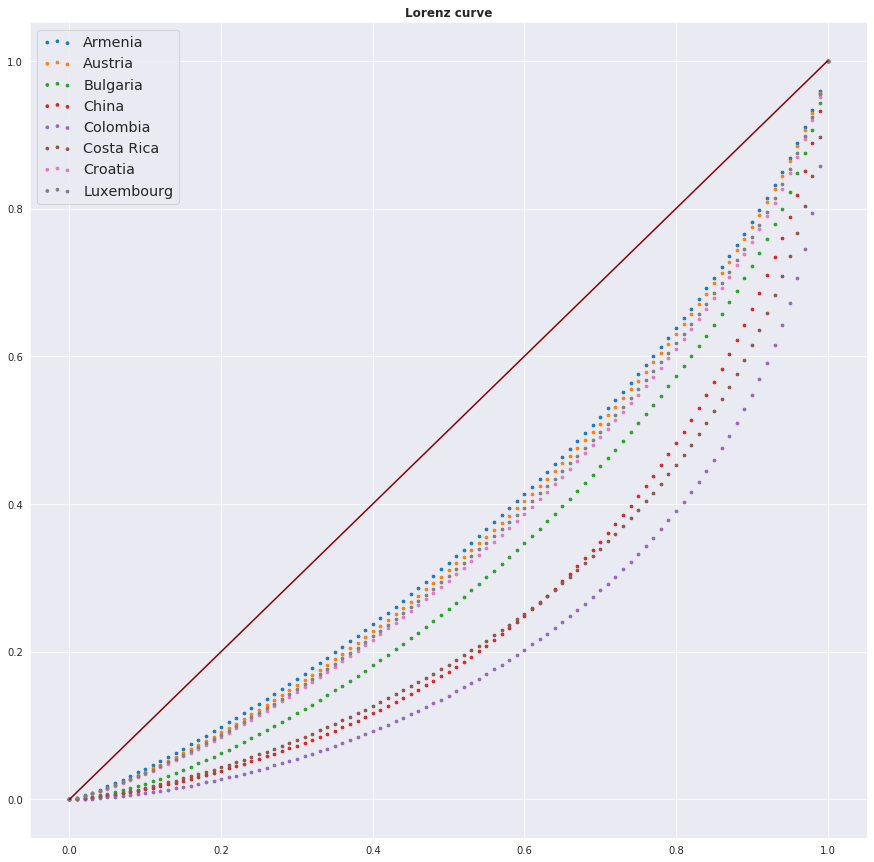

In [127]:
def lorenz_curve(X):
    X_lorenz = X.cumsum() / X.sum()
    X_lorenz = np.insert(X_lorenz, 0, 0) 
    return X_lorenz

fig, ax = plt.subplots(1, 1, figsize=(15,15))
legend = []


for k in range(select_quantile.shape[1]): 
    income_sorted = select_quantile[select_quantile.columns[k]].sort_values(ascending=True)
    lorenz = lorenz_curve(income_sorted.values)
    x = np.arange(len(lorenz))/(len(lorenz)-1)
    
    ax.scatter(x, lorenz, marker='.', s=30, cmap=sns.color_palette())
    legend.append(select_quantile.columns[k][1])
    ax.legend(legend, loc='upper left', fontsize = 'x-large', scatterpoints = 3)
    
ax.plot([0,1], [0,1], color = '#8B0000')
plt.title("Lorenz curve", weight = 'bold')

plt.savefig('data/output_graphics/fig_lorenz.png', transparent=True)
plt.show()

<h3>Plot: Evolution of the GINI Index from 2008 to 2016</h3><a id='gini_evo'></a>

In [96]:
select_gini = gini_complete.loc[gini_complete.index.isin(country_selected)]
select_gini = select_gini.drop(['gini_2004', 'gini_2005', 'gini_2006', 'gini_2007', 
                                'country_alpha3', 'cluster', 'gini_mean'], axis=1)
select_gini = select_gini.transpose()
select_gini.index = ['2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016']
select_gini

country,Armenia,Austria,Bulgaria,Colombia,Costa Rica,Croatia,Luxembourg,China
2008,29.2,30.4,33.6,55.5,48.7,30.3,32.6,43.0
2009,28.0,31.5,33.8,54.4,50.6,32.6,31.2,NaN
2010,30.0,30.3,35.7,54.7,48.2,32.4,30.5,43.7
2011,29.4,30.8,34.3,53.5,48.7,32.3,32.1,42.4
2012,29.6,30.5,36.0,52.7,48.6,32.5,34.3,42.2
2013,30.6,30.8,36.6,52.8,49.3,32.0,32.0,39.7
2014,31.5,30.5,37.4,52.7,48.6,32.1,31.2,39.2
2015,32.4,30.5,38.6,51.1,48.4,31.1,33.8,38.6
2016,32.5,30.8,40.6,50.8,48.7,30.9,33.0,38.5


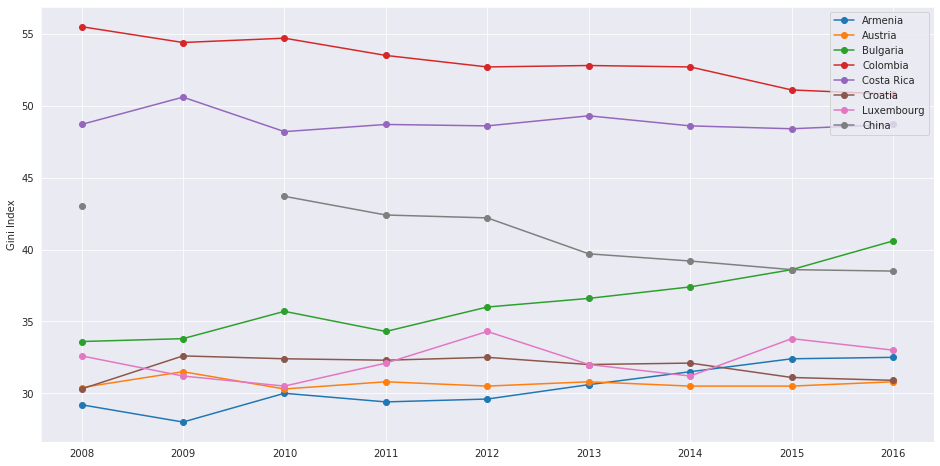

In [97]:
fig = plt.figure(figsize=(16,8))

for k in range(select_gini.shape[1]): 
    plt.plot(select_gini[select_gini.columns[k]],"-o", label=select_gini.columns[k])

plt.grid(True)
plt.legend(loc='upper right')
plt.ylabel('Gini Index')
plt.show()

<h3>GINI Ranking (2007-2009)</h3><a id='gini_rank'></a>

In [104]:
gini.describe()

,gini_2004,gini_2005,gini_2006,gini_2007,gini_2008,gini_2009,gini_2010,gini_2011,gini_2012,gini_2013,gini_2014,gini_2015,gini_2016,gini_mean,cluster
count,72.000000,75.000000,74.000000,76.000000,88.000000,79.000000,85.000000,77.000000,79.000000,76.000000,80.000000,80.000000,76.000000,160.000000,96.000000
mean,38.115278,39.173333,37.722973,36.797368,37.055682,37.644304,36.617647,36.468831,36.449367,36.539474,36.648750,36.813750,36.378947,38.670000,4.864583
std,9.223037,9.396683,8.950986,8.005581,8.540853,8.749414,8.147585,8.195767,7.546265,7.352933,8.100836,7.940885,7.603636,7.832008,2.364740
min,24.800000,24.600000,24.400000,24.400000,23.700000,24.800000,24.800000,24.600000,24.700000,24.600000,24.000000,25.400000,24.800000,24.900000,1.000000
25%,30.575000,31.650000,30.225000,31.100000,31.050000,31.300000,30.500000,30.500000,29.550000,30.775000,31.125000,31.550000,31.125000,32.675000,4.000000
50%,35.400000,37.400000,35.500000,35.100000,34.750000,35.400000,34.100000,34.300000,35.600000,36.200000,35.150000,35.750000,35.100000,37.500000,5.000000
75%,45.575000,46.300000,44.300000,40.775000,43.050000,44.150000,42.400000,42.400000,41.250000,40.925000,40.900000,41.125000,41.525000,43.500000,6.000000
max,58.100000,64.800000,57.500000,55.800000,63.000000,61.000000,63.400000,56.800000,56.100000,52.800000,63.000000,59.100000,54.600000,63.600000,8.000000


In [105]:
gini_rank = gini[['gini_2008', 'gini_2009', 'gini_2010']].copy()
gini_rank['gini_2008_2010'] = gini_rank.mean(axis=1).round(1)
gini_rank.sort_values(by='gini_2008_2010', inplace=True)
gini_rank.reset_index(inplace=True)
gini_rank.dropna(subset=['gini_2008_2010'], inplace=True)
gini_rank

,country,gini_2008,gini_2009,gini_2010,gini_2008_2010
0,Slovenia,23.7,24.8,24.9,24.5
1,Ukraine,26.6,25.3,24.8,25.6
2,Norway,27.0,26.2,25.7,26.3
3,Denmark,25.2,26.7,27.2,26.4
4,Czech Republic,26.3,26.2,26.6,26.4
...,...,...,...,...,...
116,Zambia,NaN,NaN,55.6,55.6
117,Central African Republic,56.2,NaN,NaN,56.2
118,Botswana,NaN,60.5,NaN,60.5
119,Namibia,NaN,61.0,NaN,61.0


In [106]:
'Mean of GINI Index for the {} countries with available data : {}'.format(
    len(gini_rank), round(np.mean(gini_rank['gini_2008_2010']),1))

'Mean of GINI Index for the 121 countries with available data : 38.2'

In [107]:
# 5 countries with higest GINI index (highest level of inequality)
gini_rank.nlargest(5, 'gini_2008_2010')

,country,gini_2008,gini_2009,gini_2010,gini_2008_2010
120,South Africa,63.0,NaN,63.4,63.2
119,Namibia,NaN,61.0,NaN,61.0
118,Botswana,NaN,60.5,NaN,60.5
117,Central African Republic,56.2,NaN,NaN,56.2
116,Zambia,NaN,NaN,55.6,55.6


In [108]:
# 5 countries with lowest GINI index (highest level of equality)
gini_rank.nsmallest(5, 'gini_2008_2010')

,country,gini_2008,gini_2009,gini_2010,gini_2008_2010
0,Slovenia,23.7,24.8,24.9,24.5
1,Ukraine,26.6,25.3,24.8,25.6
2,Norway,27.0,26.2,25.7,26.3
3,Denmark,25.2,26.7,27.2,26.4
4,Czech Republic,26.3,26.2,26.6,26.4


In [109]:
'France Gini Index is {}, ranked {} over {} countries'.format(
    gini_rank.loc[gini_rank['country']=='France']['gini_2008_2010'].values, 
    gini_rank.loc[gini_rank['country']=='France'].index[0], 
    len(gini_rank))

'France Gini Index is [33.1], ranked 40 over 121 countries'

<h2>Mission 3</h2><a id='mission 3'></a>

In [110]:
def generate_incomes(n, pj):
# On génère les revenus des parents (exprimés en logs) selon une loi normale.
# La moyenne et variance n'ont aucune incidence sur le résultat final (ie. sur le caclul de la classe de revenu)

    ln_y_parent = st.norm(0,1).rvs(size=n)

    #Génération d'une réalisation du terme d'erreur epsilon
    residues = st.norm(0,1).rvs(size=n)
    
    return np.exp(pj*ln_y_parent + residues), np.exp(ln_y_parent)

In [111]:
def quantiles(l, nb_quantiles):
    size = len(l)
    l_sorted = l.copy()
    l_sorted = l_sorted.sort_values()
    quantiles = np.round(np.arange(1, nb_quantiles+1, nb_quantiles/size) -0.5 +1./size)
    q_dict = {a:int(b) for a,b in zip(l_sorted,quantiles)}
    return pd.Series([q_dict[e] for e in l])

In [112]:
def compute_quantiles(y_child, y_parents, nb_quantiles):
    y_child = pd.Series(y_child)
    y_parents = pd.Series(y_parents)
    c_i_child = quantiles(y_child, nb_quantiles)
    c_i_parent = quantiles(y_parents, nb_quantiles)
    sample = pd.concat([y_child, y_parents, c_i_child, c_i_parent], axis=1)
    sample.columns = ["y_child", "y_parents", "c_i_child","c_i_parent"]
    return sample

In [113]:
def distribution(counts, nb_quantiles):
    distrib = []
    total = counts["counts"].sum()

    if total == 0 :
        return [0] * nb_quantiles

    for q_p in range(1, nb_quantiles+1):
        subset = counts[counts.c_i_parent == q_p]
        
        if len(subset):
            nb = subset["counts"].values[0]
            distrib += [nb / total]
    
        else:
            distrib += [0]
    
    return distrib

In [114]:
def conditional_distributions(sample, nb_quantiles):

    counts = sample.groupby(["c_i_child","c_i_parent"]).apply(len)
    counts = counts.reset_index()

    counts.columns = ["c_i_child","c_i_parent","counts"]

    mat = []
    for child_quantile in np.arange(nb_quantiles)+1:

        subset = counts[counts.c_i_child == child_quantile]
        mat += [distribution(subset, nb_quantiles)]
    return np.array(mat)

In [115]:
def plot_conditional_distributions(p, cd, nb_quantiles):
    plt.figure(figsize=(16,8))

    cumul = np.array([0] * nb_quantiles)
    
    for i, child_quantile in enumerate(cd):
        plt.bar(np.arange(nb_quantiles)+1, child_quantile, bottom=cumul, width=0.95, label= str(i+1) +"e")
        cumul = cumul + np.array(child_quantile)

    plt.axis([.5, nb_quantiles*1.3 ,0 ,1])
    plt.title("p=" + str(p))
    plt.legend()
    plt.xlabel("quantile parents")
    plt.ylabel("probabilité du quantile enfant")
    plt.show()

In [116]:
def proba_cond(c_i_parent, c_i_child, mat):
    return mat[c_i_child, c_i_parent]

In [117]:
pj = 0.9 # coefficient d'élasticité du pays j
nb_quantiles = 10 # nombre de quantiles (nombre de classes de revenu)
n = 1000*nb_quantiles # taille de l'échantillon

In [118]:
y_child, y_parents = generate_incomes(n, pj)

In [119]:
sample = compute_quantiles(y_child, y_parents, nb_quantiles)
sample

,y_child,y_parents,c_i_child,c_i_parent
0,5.056978,7.192337,9,10
1,1.327622,0.950219,6,5
2,0.322791,0.556348,3,3
3,0.871792,0.409292,5,2
4,0.292462,0.858330,2,5
...,...,...,...,...
9995,1.812021,1.328038,7,7
9996,0.190630,0.192673,2,1
9997,0.173108,0.173568,2,1
9998,0.789111,0.968584,5,5


In [120]:
cd = conditional_distributions(sample, nb_quantiles)

In [121]:
#X-axis is parents
#Y-axis is child
pd.DataFrame(cd)

,0,1,2,3,4,5,6,7,8,9
0,0.440,0.229,0.133,0.083,0.049,0.025,0.020,0.012,0.008,0.001
1,0.225,0.201,0.182,0.132,0.103,0.058,0.045,0.037,0.012,0.005
2,0.127,0.164,0.160,0.153,0.120,0.108,0.069,0.053,0.037,0.009
3,0.075,0.139,0.148,0.141,0.128,0.120,0.104,0.088,0.046,0.011
4,0.064,0.103,0.128,0.103,0.131,0.143,0.128,0.092,0.069,0.039
5,0.028,0.072,0.086,0.129,0.123,0.118,0.138,0.141,0.105,0.060
6,0.025,0.045,0.073,0.089,0.111,0.146,0.130,0.149,0.139,0.093
7,0.012,0.035,0.046,0.082,0.106,0.135,0.139,0.160,0.167,0.118
8,0.002,0.010,0.034,0.061,0.089,0.087,0.137,0.139,0.214,0.227
9,0.002,0.002,0.010,0.027,0.040,0.060,0.090,0.129,0.203,0.437


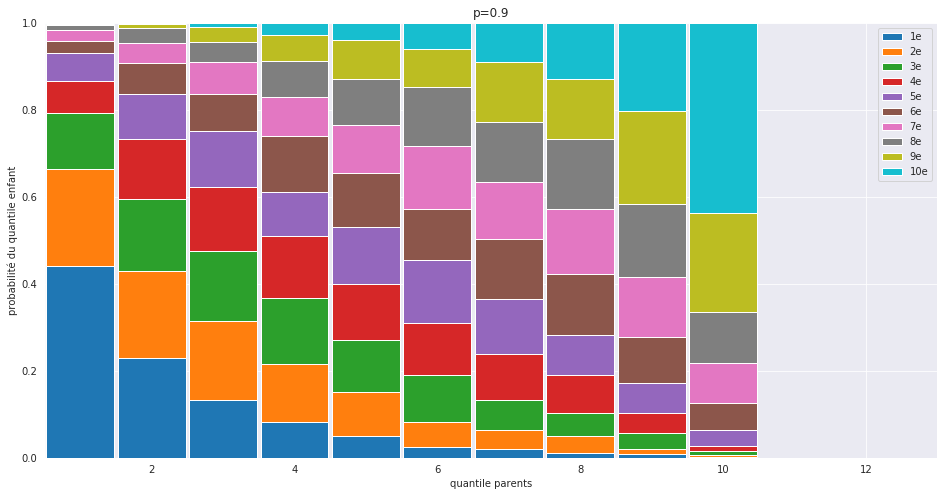

In [122]:
plot_conditional_distributions(pj, cd, nb_quantiles)

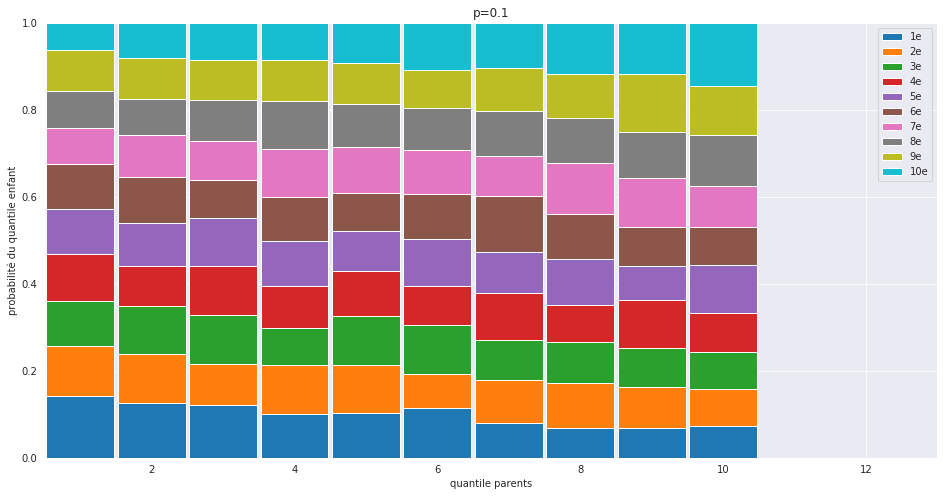

In [123]:
# another example with pj = 0.1

pj = 0.1 
nb_quantiles = 10 
n = 1000*nb_quantiles 

y_child, y_parents = generate_incomes(n, pj)
sample = compute_quantiles(y_child, y_parents, nb_quantiles)
cd = conditional_distributions(sample, nb_quantiles)

plot_conditional_distributions(pj, cd, nb_quantiles)

In [124]:
del sample, y_child, y_parents

In [125]:
#clone population * 1000

pop_clone = pd.concat([income_disti]*1000, ignore_index=True)
pop_clone

,country_alpha3,year_survey,quantile,nb_quantiles,income,gdpppp,country,population
0,ALB,2008,1,100,728.89795,7297.00000,Albania,3002678.0
1,ALB,2008,2,100,916.66235,7297.00000,Albania,3002678.0
2,ALB,2008,3,100,1010.91600,7297.00000,Albania,3002678.0
3,ALB,2008,4,100,1086.90780,7297.00000,Albania,3002678.0
4,ALB,2008,5,100,1132.69970,7297.00000,Albania,3002678.0
...,...,...,...,...,...,...,...,...
11599995,COD,2008,97,100,911.78340,303.19305,Democratic Republic of the Congo,60411195.0
11599996,COD,2008,98,100,1057.80740,303.19305,Democratic Republic of the Congo,60411195.0
11599997,COD,2008,99,100,1286.60290,303.19305,Democratic Republic of the Congo,60411195.0
11599998,COD,2008,100,100,2243.12260,303.19305,Democratic Republic of the Congo,60411195.0
